<a href="https://colab.research.google.com/github/BDouchet/Spotify_dataset/blob/main/genre_classification/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='16phKfXvRrwGbOJrNKpgbYnBnZG6icXFX'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dataset.zip')

with ZipFile('dataset.zip', 'r') as zip:
   zip.extractall()
   print('Done')

df=pd.read_csv('dataset/Spotify_train_dataset.csv')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data=df.drop(labels=['type','id','uri','track_href','analysis_url','song_name'],axis=1)

genres=['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB', 'Pop', 'Hiphop', 'techhouse', 'techno',
'trance', 'psytrance', 'trap', 'dnb', 'hardstyle']

le = LabelEncoder()
le.classes_=genres
data['genre']=le.transform(data['genre'])

X=data[data.columns[:-1]].to_numpy()
Y=data['genre'].to_numpy()

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=10,test_size=0.2)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

Done
(25382, 13) (25382,) (6346, 13) (6346,)


# Create and train model

Similarly to Neural Networks, it is essential to standardize our values and to one-hot encode the labels.

Convolutionnal Neural Networks (CNN) are different from Neural Networks (NN) because they use convolutionnal filters. This operation consists in multiplying term by term the filter with the input volume and to sum the products. 

It is mainly use to process 2D and 3D images. But it can be used with 1D data by applying [`Conv1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D).

Another important operation is `Pooling` where we apply a filter in order to reduce the size of the input volume. Many operations can be performed like average, maximum, minimum ... The core idea is to get a smaller reprsentation of the input data.

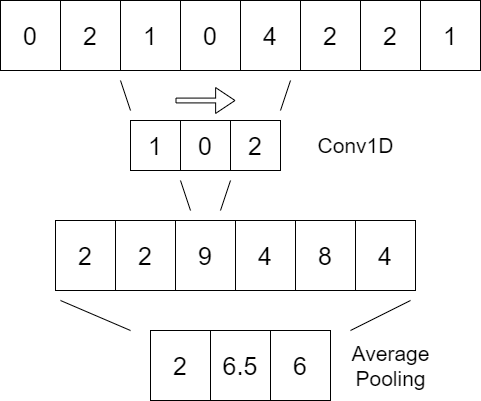

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [ ]:
def to_labels(Y):
    return np.array([np.argmax(y) for y in Y ])

In [ ]:
ss=StandardScaler()

x_train=np.expand_dims(ss.fit_transform(X_train),-1)
x_test=np.expand_dims(ss.fit_transform(X_test),-1)

y_train=tf.keras.utils.to_categorical(Y_train)
y_test=tf.keras.utils.to_categorical(Y_test)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25382, 13, 1) (6346, 13, 1) (25382, 15) (6346, 15)


## CNN1 - Successive

Composed of 4 successive Conv1D layers with BatchNormalization and Dropout. The end is made of two fully-connected layers (64 -> 15). The number of parameteres is equal to 59,855.

In [ ]:
cnn1=models.Sequential()

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu',input_shape=(13,1)))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Conv1D(64,3,padding='valid',activation='relu'))
cnn1.add(layers.BatchNormalization())
cnn1.add(layers.Dropout(0.2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64,activation='relu'))
cnn1.add(layers.Dropout(0.2))
cnn1.add(layers.Dense(15,activation='softmax'))

cnn1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 11, 64)            256       
_________________________________________________________________
batch_normalization_21 (Batc (None, 11, 64)            256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 9, 64)             12352     
_________________________________________________________________
batch_normalization_22 (Batc (None, 9, 64)             256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 64)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 7, 64)            

In [ ]:
cnn1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
history1=cnn1.fit(x_train,y_train,epochs=80,batch_size=128,verbose=2,shuffle=True,validation_data=(x_test,y_test))

Epoch 1/80
199/199 - 5s - loss: 1.8984 - acc: 0.3874 - val_loss: 1.7731 - val_acc: 0.3547
Epoch 2/80
199/199 - 4s - loss: 1.3784 - acc: 0.5226 - val_loss: 1.1499 - val_acc: 0.6072
Epoch 3/80
199/199 - 4s - loss: 1.2507 - acc: 0.5649 - val_loss: 1.0386 - val_acc: 0.6322
Epoch 4/80
199/199 - 4s - loss: 1.1807 - acc: 0.5835 - val_loss: 1.0069 - val_acc: 0.6412
Epoch 5/80
199/199 - 4s - loss: 1.1432 - acc: 0.5983 - val_loss: 0.9889 - val_acc: 0.6437
Epoch 6/80
199/199 - 4s - loss: 1.1102 - acc: 0.6069 - val_loss: 0.9762 - val_acc: 0.6464
Epoch 7/80
199/199 - 4s - loss: 1.0961 - acc: 0.6119 - val_loss: 0.9630 - val_acc: 0.6522
Epoch 8/80
199/199 - 4s - loss: 1.0809 - acc: 0.6158 - val_loss: 0.9608 - val_acc: 0.6560
Epoch 9/80
199/199 - 4s - loss: 1.0652 - acc: 0.6197 - val_loss: 0.9534 - val_acc: 0.6541
Epoch 10/80
199/199 - 4s - loss: 1.0504 - acc: 0.6234 - val_loss: 0.9455 - val_acc: 0.6596
Epoch 11/80
199/199 - 4s - loss: 1.0463 - acc: 0.6275 - val_loss: 0.9408 - val_acc: 0.6599
Epoch 12

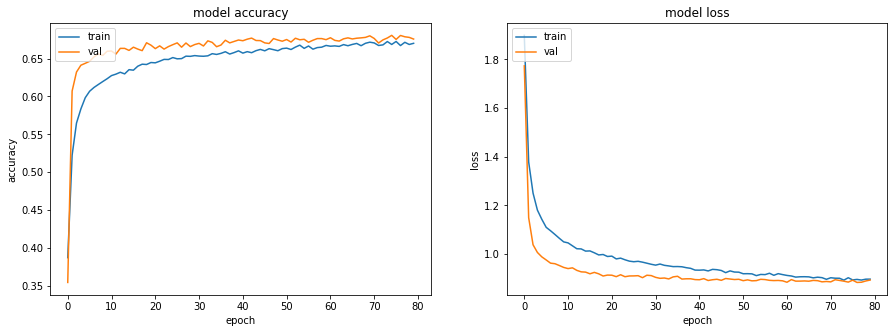

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history1.history['acc'])
ax1.plot(history1.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_train=cnn1.predict(x_train)
yhat_test=cnn1.predict(x_test)

print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.7149948782601845
0.675701229120706


## CNN2 - Parallel

This CNN is inspired (with a lot of imagination) from [ASPP](https://arxiv.org/pdf/1706.05587.pdf) (Atrous Spatial Pyramid Pooling). The idea is to proceed the volume in parallel with different dilation rates and kernel sizes. The proceeded volumes are then concatenated. The total number of parameters is equal to 54,991. This CNN has more convolutionnal layers but the number of filters is lower than in the first CNN.

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 13, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_148 (Conv1D)             (None, 11, 32)       128         input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_146 (BatchN (None, 11, 32)       128         conv1d_148[0][0]                 
__________________________________________________________________________________________________
dropout_154 (Dropout)           (None, 11, 32)       0           batch_normalization_146[0][0]    
___________________________________________________________________________________________

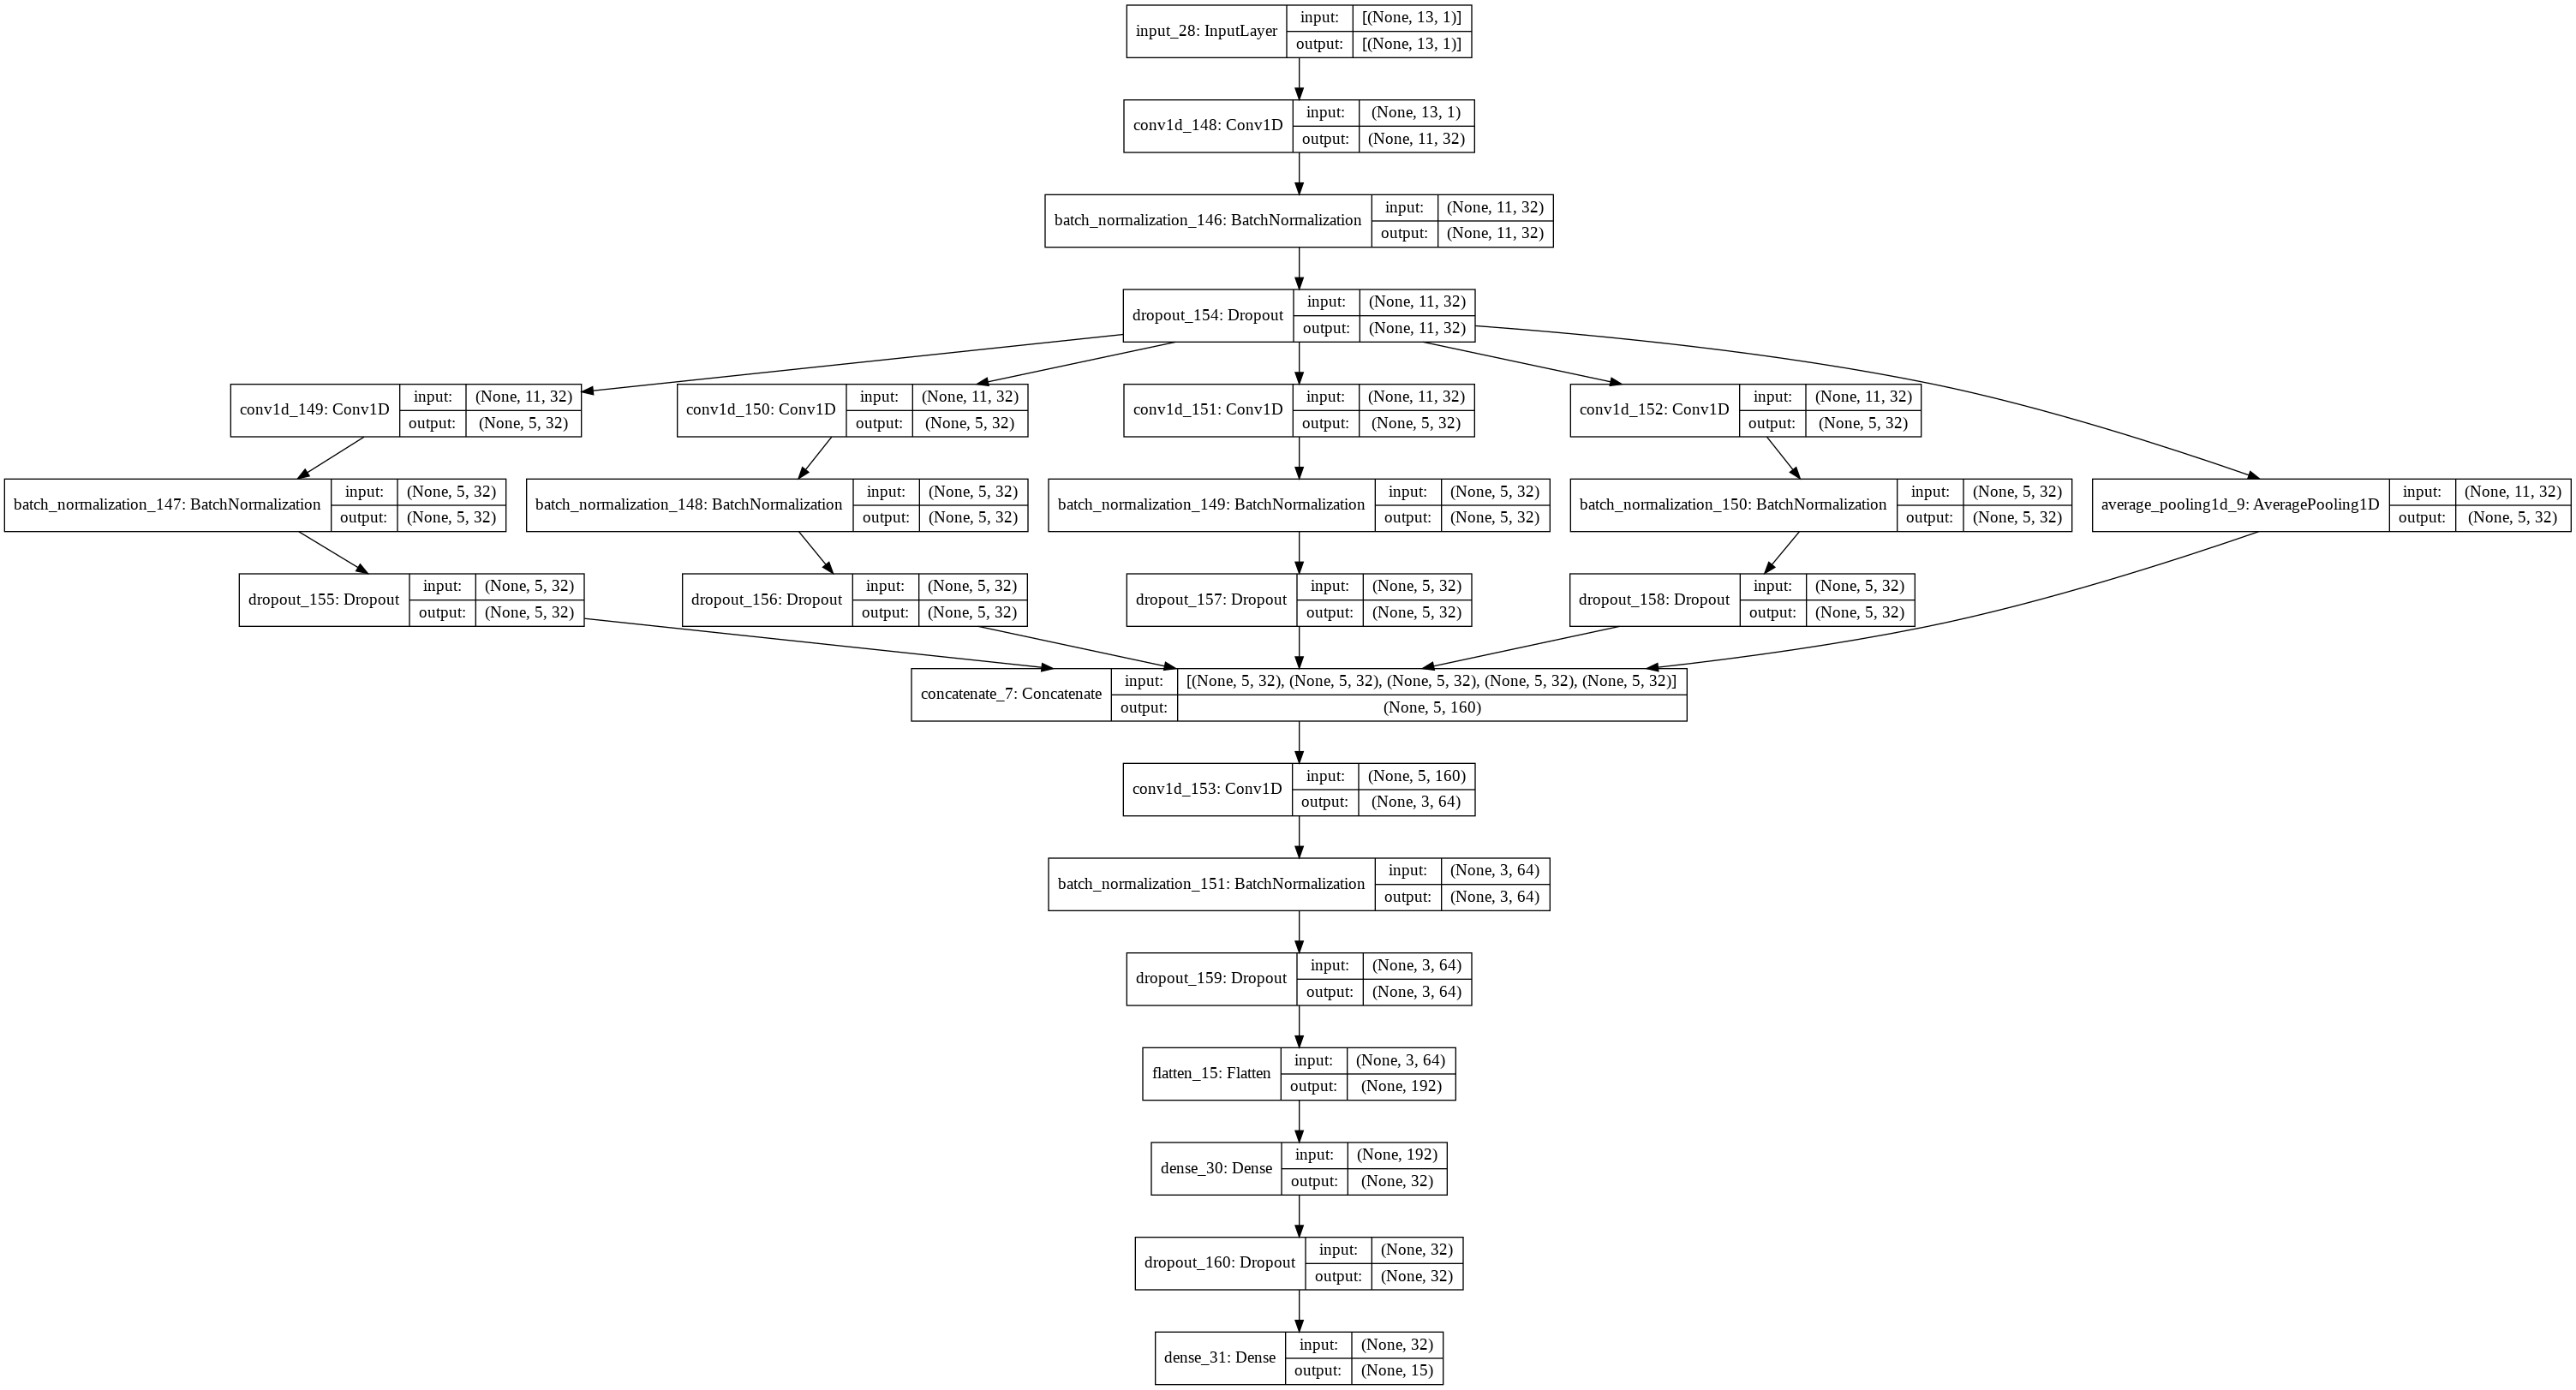

In [ ]:
input=layers.Input(shape=(13,1))

x=layers.Conv1D(32,3,padding='valid',activation='relu')(input)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)

b0=layers.Conv1D(32,7,padding='valid',activation='relu',dilation_rate=1)(x)
b0=layers.BatchNormalization()(b0)
b0=layers.Dropout(0.2)(b0)

b1=layers.Conv1D(32,4,padding='valid',activation='relu',dilation_rate=2)(x)
b1=layers.BatchNormalization()(b1)
b1=layers.Dropout(0.2)(b1)

b2=layers.Conv1D(32,3,padding='valid',activation='relu',dilation_rate=3)(x)
b2=layers.BatchNormalization()(b2)
b2=layers.Dropout(0.2)(b2)

b3=layers.Conv1D(32,2,padding='valid',activation='relu',dilation_rate=6)(x)
b3=layers.BatchNormalization()(b3)
b3=layers.Dropout(0.2)(b3)

b4=layers.AveragePooling1D()(x)

x=layers.Concatenate()([b0,b1,b2,b3,b4])

x=layers.Conv1D(64,3,padding='valid',activation='relu')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(0.2)(x)

x=layers.Flatten()(x)
x=layers.Dense(32,activation='relu')(x)
x=layers.Dropout(0.2)(x)

output=layers.Dense(15,activation='softmax')(x)

cnn2=models.Model(input,output)

cnn2.summary()

tf.keras.utils.plot_model(cnn2,show_shapes=True)

In [ ]:
cnn2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
history2=cnn2.fit(x_train,y_train,epochs=80,batch_size=128,verbose=2,shuffle=True,validation_data=(x_test,y_test))

Epoch 1/80
199/199 - 6s - loss: 1.8181 - acc: 0.4133 - val_loss: 1.5673 - val_acc: 0.5314
Epoch 2/80
199/199 - 3s - loss: 1.3640 - acc: 0.5335 - val_loss: 1.1331 - val_acc: 0.6150
Epoch 3/80
199/199 - 3s - loss: 1.2501 - acc: 0.5691 - val_loss: 1.0491 - val_acc: 0.6336
Epoch 4/80
199/199 - 3s - loss: 1.1887 - acc: 0.5859 - val_loss: 1.0165 - val_acc: 0.6407
Epoch 5/80
199/199 - 3s - loss: 1.1519 - acc: 0.5961 - val_loss: 1.0032 - val_acc: 0.6443
Epoch 6/80
199/199 - 3s - loss: 1.1302 - acc: 0.6018 - val_loss: 0.9776 - val_acc: 0.6522
Epoch 7/80
199/199 - 3s - loss: 1.1094 - acc: 0.6085 - val_loss: 0.9703 - val_acc: 0.6544
Epoch 8/80
199/199 - 3s - loss: 1.0860 - acc: 0.6151 - val_loss: 0.9594 - val_acc: 0.6581
Epoch 9/80
199/199 - 3s - loss: 1.0798 - acc: 0.6143 - val_loss: 0.9608 - val_acc: 0.6565
Epoch 10/80
199/199 - 3s - loss: 1.0671 - acc: 0.6234 - val_loss: 0.9540 - val_acc: 0.6565
Epoch 11/80
199/199 - 3s - loss: 1.0557 - acc: 0.6277 - val_loss: 0.9436 - val_acc: 0.6620
Epoch 12

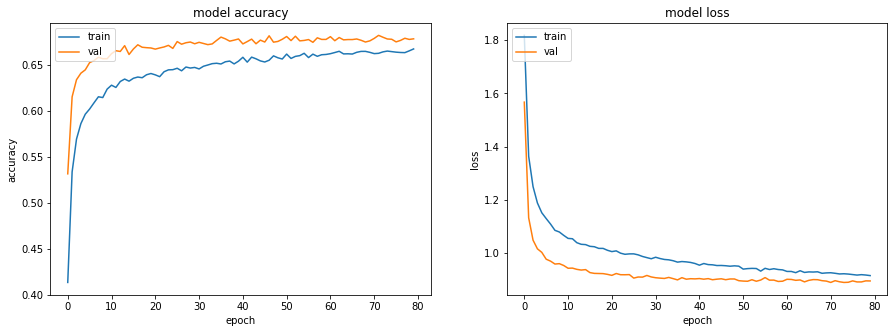

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history2.history['acc'])
ax1.plot(history2.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
yhat_train=cnn2.predict(x_train)
yhat_test=cnn2.predict(x_test)

print(f1_score(Y_train,to_labels(yhat_train),average='micro'))
print(f1_score(Y_test,to_labels(yhat_test),average='micro'))

0.7099519344417304
0.6780649227860069
